## Continuous Time Markov Chain (CTMC) 

The goal here is to compute the expected # steps a particle would take before leaving the system, which can be computed with the following equations:

Probability that a walker will leave the system after $n$ steps, conditioned on the fact that it did not leave the system in a previous step:

$p_n= 1^T(I+\alpha{}\tilde{D})^{-1} (\tilde{W}\tilde{D}^{-1})^n s$ 

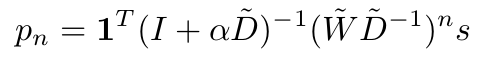

Here is the equation for the expected number of transitions taken by the particle before it leaves the system (see screenshot):

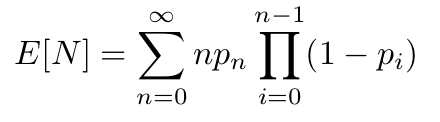

And the variance (see screenshot):

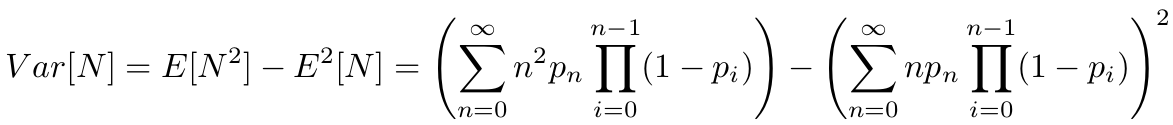

In [1]:
# the rest of the imports require the location to be the base of the repo 
#   i.e., SARS-CoV-2-network-analysis)
# run this first if needed to get to the right directory
import os
os.chdir('../../../')
# os.chdir('/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis')
os.getcwd()

'/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis'

In [2]:
from collections import defaultdict
import argparse
import os, sys
from tqdm import tqdm
import itertools
#import utils.file_utils as utils
# also compute the significance of sinksource vs local
import scipy
from scipy import sparse as sp
import networkx as nx
# plotting imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns
import numpy as np
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % matplotlib.__version__)
print("seaborn version: %s" % sns.__version__)
print("pandas version: %s" % pd.__version__)
print("numpy version: %s" % (np.__version__))
# make this the default for now
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1.2)

# my local imports
# fss_dir = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
# sys.path.insert(0,fss_dir)
from src.FastSinkSource.src import main as run_eval_algs
from src.FastSinkSource.src.plot import plot_utils
from src.FastSinkSource.src.algorithms import runner
from src.FastSinkSource.src.algorithms import alg_utils
from src.FastSinkSource.src.utils import config_utils
from src.FastSinkSource.src.evaluate import cross_validation as cv
from src.FastSinkSource.src.algorithms import rl_genemania_runner as gm_runner
from src.FastSinkSource.src.algorithms import rl_genemania as gm
from src.FastSinkSource.src.evaluate import stat_sig

%matplotlib inline

python version: 3.7.7 (default, Mar 13 2020, 13:32:22) 
matplotlib version: 3.2.1
seaborn version: 0.10.0
pandas version: 1.0.3
numpy version: 1.18.2


In [3]:
# first load the datasets from the config file
config_file = "fss_inputs/config_files/string-tissuenet-wace2/string.yaml"
# also try on the Lung network
# config_file = "fss_inputs/config_files/string-tissuenet-wace2/tissuenet-hpar-lung.yaml"
print(config_file)
config_map = plot_utils.load_config_file(config_file)
kwargs = {}
# extract the general variables from the config map                                                                                                                                       
input_settings, input_dir, output_dir, alg_settings, kwargs = config_utils.setup_config_variables(config_map, **kwargs)   
kwargs['sarscov2_human_ppis'] = 'datasets/protein-networks/2020-03-biorxiv-krogan-sars-cov-2-human-ppi-ace2.tsv'
                                                                                                                                                           
# or we could get a distribution of distances for each virus node                                                                                                                         
# load human-virus ppis                                                                                                                                                                   
df = pd.read_csv(kwargs['sarscov2_human_ppis'], sep='\t')
edges = zip(df[df.columns[0]], df[df.columns[1]])
edges = [(v.replace("SARS-CoV2 ",""), h) for v,h in edges]
virus_nodes = [v for v,h in edges]
krogan_nodes = [h for v,h in edges]
virhost_edges = edges
                                                                                                                                                                             
# for each dataset, extract the path(s) to the prediction files,                                                                                                                          
# read in the predictions, and test for the statistical significance of overlap                                                                                                           
for dataset in input_settings['datasets']:                                                                                                                                                
    dataset_name = config_utils.get_dataset_name(dataset)                                                                                                                                 
    print("Loading data for %s" % (dataset['net_version']))                                                                                                                               
    # load the network and the positive examples for each term                                                                                                                            
    net_obj, ann_obj, eval_ann_obj = run_eval_algs.setup_dataset(                                                                                                                         
        dataset, input_dir, **kwargs)                                                                                                                                                     
    prots, node2idx = net_obj.nodes, net_obj.node2idx                                                                                                                                     
    print("\t%d total prots" % (len(prots)))                                                                                                                                              
    # TODO using this for the SARS-CoV-2 project,                                                                                                                                         
    # but this should really be a general purpose script                                                                                                                                  
    # and to work on any number of terms                                                                                                                                                  
    orig_pos_idx, _ = alg_utils.get_term_pos_neg(ann_obj.ann_matrix, 0)                                                                                                                   
    orig_pos = [prots[p] for p in orig_pos_idx]                                                                                                                                           
    print("\t%d original positive examples" % (len(orig_pos)))                                                                                                                            

    W = net_obj.W 
    
#     print("converting network to networkx graph")                                                                                                                                  
#     G = nx.from_scipy_sparse_matrix(W) 

fss_inputs/config_files/string-tissuenet-wace2/string.yaml
Loading data for networks/stringv11/400
	reading sparse nets from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from fss_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-ace2-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components sizes:
18886
329/329 (100.00%) pos prots are in the largest cc
	18886 total prots
	329 original positive examples


In [4]:
# create a matrix with 1/sqrt(degree) of each node on the diagonal
deg = np.asarray(W.sum(axis=0)).flatten()
deg = np.divide(1., np.sqrt(deg))
deg[np.isinf(deg)] = 0
D = sp.diags(deg)
# normalize W by multiplying D^(-1/2) * W * D^(-1/2)
P = D.dot(W.dot(D))

# and get the degree of the normalized matrix as well
deg = np.asarray(P.sum(axis=0)).flatten()
D_P = sp.diags(deg)
# L = D2 - P

In [5]:
# Precompute some of the necessary dot products to minimize repeated computations
# (\tilde{W} \tilde{D}^{-1})
D_inv = sp.diags(np.divide(1, deg))
P_dot_Dinv = P.dot(D_inv)

In [6]:
# set a value of 1/# starting nodes for each starting node (i.e., Krogan nodes)
s = np.zeros(P.shape[0], dtype=np.float64)
s[orig_pos_idx] = 1./float(len(orig_pos_idx))

# or from all nodes:
# s = np.ones(P.shape[0]) * (1./P.shape[0])

In [7]:
# compute the expected number of transitions taken by the particle before it leaves the system
print("alpha\tE_N\tVar_N\t# iters")
for alpha in list((3+np.arange(10)*0.1)) + [1,2,3,4,6,8,10]:
    # first pre-compute (I + \alpha \tilde{D})^-1
    C = sp.eye(P.shape[0]) + alpha*D_P
    C.data = np.divide(1, C.data)
    # use higher precision
    C = C.astype(dtype=np.float128)
    P_dot_Dinv = P_dot_Dinv.astype(dtype=np.float128)
    s = s.astype(dtype=np.float128)
    # compute the probably that the walker took no steps
    p_0 = np.sum(C.dot(s))
    prob_values = [1-p_0]
    n = 1
    # Because of the associative property of matrix multiplication, 
    # we can compute the first (\tilde{W} \tilde{D}^{-1})*s here,
    # and then premultiply by (\tilde{W} \tilde{D}^{-1}) to get (\tilde{W} \tilde{D}^{-1})^n
    P_dot_Dinv_n_dot_s = P_dot_Dinv.dot(s)    
    E_N = 0
    E_N_prev = 0
    # store this value as well for computing the variance
    E_N_2 = 0
    while n < 1000:
        if n > 1:
            # compute (\tilde{W} \tilde{D}^{-1})^n * s
            P_dot_Dinv_n_dot_s = P_dot_Dinv.dot(P_dot_Dinv_n_dot_s)
        # compute the conditional probability p_n
        p_n = np.sum(C.dot(P_dot_Dinv_n_dot_s))
        # then make it unconditional by multiplying by (1-p_i) from 0 to n-1
        # and multiply by n to get the probability for the current # steps
        curr_step_prob = n * p_n * np.prod(prob_values)
        E_N_prev = E_N
        E_N += curr_step_prob
        # also compute the first half of the variance equation at N
        curr_step_var_prob = ((n**2) * p_n * np.prod(prob_values))
        E_N_2 += curr_step_var_prob
    #     print("n: {}, p_n: {}, curr_step_prob: {}, E_N: {}, E_N - E_N_prev: {}".format(n, p_n, curr_step_prob, E_N, E_N - E_N_prev))
        # since the difference of E_N will keep getting smaller, we can stop when we have enough precision
        if E_N - E_N_prev < 0.0001:
            break

        n += 1
        prob_values.append(1-p_n)
        
    # Now combine the second half of the variance equation using E_N
    Var_N = E_N_2 - (E_N**2)
    
    print("%s\t%0.4f\t%0.4f\t%d" % (alpha, E_N, Var_N, n))

alpha	E_N	Var_N	# iters
3.0	2.6974	9.7093	36
3.1	2.7842	10.2569	37
3.2	2.8708	10.8188	38
3.3	2.9574	11.3950	39
3.4	3.0439	11.9854	40
3.5	3.1304	12.5901	41
3.6	3.2167	13.2091	42
3.7	3.3031	13.8423	43
3.8	3.3893	14.4897	44
3.9	3.4755	15.1514	45
1	0.9360	1.7707	16
2	1.8248	5.0198	26
3	2.6974	9.7093	36
4	3.5617	15.8273	46
6	5.2766	32.3328	66
8	6.9815	54.5225	86
10	8.6811	82.3939	106


In [37]:
# this is much slower because of the large matrix dot products
# compute the expected number of transitions taken by the particle before it leaves the system
alpha = 3
C = sp.eye(P.shape[0]) + alpha*D_P
p_0 = np.sum(C.dot(s))
prob_values = [1-p_0]
E_N = 0
n = 1
print(p_0)
P_dot_Dinv_n = P_dot_Dinv
while n < 50:
    if n > 1:
        P_dot_Dinv_n = P_dot_Dinv_n.dot(P_dot_Dinv)
    p_n = np.sum(C.dot(P_dot_Dinv_n).dot(s))
    curr_step_prob = n * p_n * np.prod(prob_values)
    E_N += curr_step_prob
    print("n: {}, p_n: {}, curr_step_prob: {}, E_N: {}".format(n, p_n, curr_step_prob, E_N))

    n += 1
    prob_values.append(1-p_n)

0.26290056194892875
n: 1, p_n: 0.2731390675896994, curr_step_prob: 0.201330653230161, E_N: 0.201330653230161
n: 2, p_n: 0.27081472748784124, curr_step_prob: 0.29018815491553335, E_N: 0.4915188081456944
n: 3, p_n: 0.2739462039251334, curr_step_prob: 0.32107155915508667, E_N: 0.812590367300781
n: 4, p_n: 0.27305650186407926, curr_step_prob: 0.30981084011616633, E_N: 1.1224012074169474
n: 5, p_n: 0.2746370208462441, curr_step_prob: 0.28314822024872055, E_N: 1.405549427665668
n: 6, p_n: 0.2741448109991229, curr_step_prob: 0.24602056936623296, E_N: 1.6515699970319009
n: 7, p_n: 0.27499193950184747, curr_step_prob: 0.2089816379896057, E_N: 1.8605516350215066
n: 8, p_n: 0.2746932583389886, curr_step_prob: 0.1729700645983496, E_N: 2.033521699619856
n: 9, p_n: 0.2751567359144844, curr_step_prob: 0.14137653467259972, E_N: 2.174898234292456
n: 10, p_n: 0.2749737533403306, curr_step_prob: 0.11378631242812548, E_N: 2.288684546720581
n: 11, p_n: 0.2752301135116544, curr_step_prob: 0.0908324742682878